In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [13]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [7]:
# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)

In [9]:
# Print all of the classes mapped to the Base
print(Base.classes.keys())

['measurement', 'station']


In [15]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [10]:
# Assign the measurement class to a variable called `Measurement` and
# the station class to a variable called `Station`
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create a session
session = Session(engine)

In [17]:
# Get a list of column names and types for measurement table
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Precipitation Analysis

In [21]:
session.query(func.count(Measurement.date)).all()

[(19550,)]

In [32]:
# Find the most recent date in the data set.
recent_date = session.query(func.max(Measurement.date)).scalar()
recent_date

'2017-08-23'

In [41]:
# Ensure recent_date is in the correct format.
# Change from string to datetime (String Parse Time)
if isinstance(recent_date, str):
    recent_date = dt.datetime.strptime(recent_date, '%Y-%m-%d')

# Calculate the date 12 months ago
date_12_months_ago = recent_date - dt.timedelta(days=365)
print("Date 12 months ago:", date_12_months_ago)

Date 12 months ago: 2016-08-23 00:00:00


In [54]:
# Design a query to retrieve the last 12 months of precipitation data.
# Starting from the most recent data point in the database.

#recent_date = session.query(func.max(Measurement.date)).scalar()

# Calculate the date one year from the last date in data set.
oldest_date = recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precip_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= oldest_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precip_df = pd.DataFrame(precip_data, columns =['date', 'precipitation']) 

# Sort the dataframe by date
precip_df = precip_df.sort_values('date')
precip_df.head()

,date,precipitation
0,2016-08-24,0.08
1006,2016-08-24,NaN
1524,2016-08-24,2.15
702,2016-08-24,2.28
360,2016-08-24,2.15


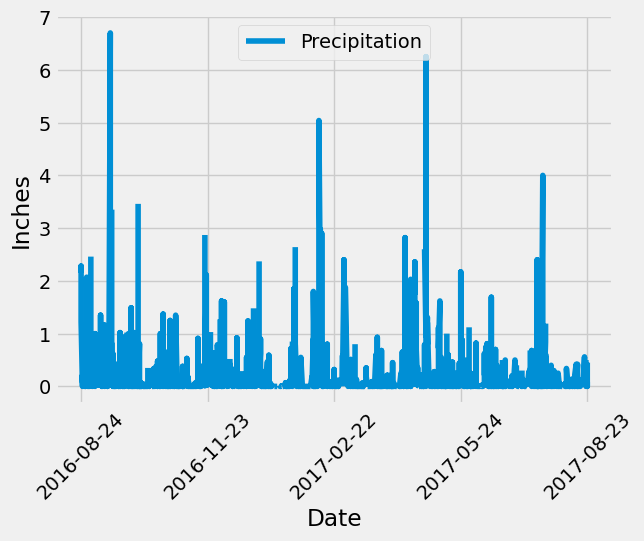

In [78]:
# Use Pandas Plotting with Matplotlib to plot the data for last 12 months from previous step

# Convert date column to datetime format to plot in matplotlib.
precip_df['date'] = pd.to_datetime(precip_df['date'])

oldest_date = precip_df['date'].min()
recent_date = precip_df['date'].max()

# Calculate the x-ticks for 1st quarter, half, 3rd quarter
first = oldest_date + (recent_date - oldest_date) / 4 
second = oldest_date + (recent_date - oldest_date) / 2
third = oldest_date + 3 * (recent_date - oldest_date) / 4

x_ticks = [oldest_date, first, second, third, recent_date]

# Create the plot and assign x, y, legend variables.
plt.plot(precip_df['date'], precip_df['precipitation'], label='Precipitation')
plt.legend(loc='upper center') #, bbox_to_anchor=(0.5, 1.05), ncol=2)
plt.xlabel('Date')
plt.ylabel('Inches')

# Set custom x-ticks 
plt.xticks(ticks=x_ticks, labels=[date.strftime('%Y-%m-%d') for date in x_ticks], rotation=45)

# Set the grid lines
plt.grid(True)

# Show the plot
plt.show()

In [47]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_df.describe()

,precipitaion
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [82]:
# Get a list of column names and types for station table
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [81]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(Station.station)).all()

[(9,)]

In [83]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
active_stations = session.query(
    Measurement.station, 
    func.count(Measurement.id).label('count')
).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).all()

# Print the results in descending order - add .desc() to function
for station, count in active_stations:
    print(f"Station: {station}, Count: {count}")


Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [88]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
low_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == 'USC00519281').scalar()
high_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == 'USC00519281').scalar()
avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').scalar()

# Round average temp to 2 decimals
avg_temp = round(avg_temp, 2)

print(f" The lowest temp is: {low_temp}, The highest temp is: {high_temp}, The average temp is: {avg_temp}")

 The lowest temp is: 54.0, The highest temp is: 85.0, The average temp is: 71.66


In [90]:
# Convert the date from string to datetime to plot with matplotlib.
recent_date_str = session.query(func.max(Measurement.date)).scalar()
recent_date = dt.datetime.strptime(recent_date_str, '%Y-%m-%d')

# Calculate date 12 months ago.
date_12_months_ago = recent_date - dt.timedelta(days=365)

# Obtain observed temps for the last 12 months for station 'USC00519281'
temp_data = session.query(Measurement.tobs).filter(
    Measurement.station == 'USC00519281',
    Measurement.date >= date_12_months_ago
).all()

# Convert the query results to a DataFrame
temp_df = pd.DataFrame(temp_data, columns=['tobs'])

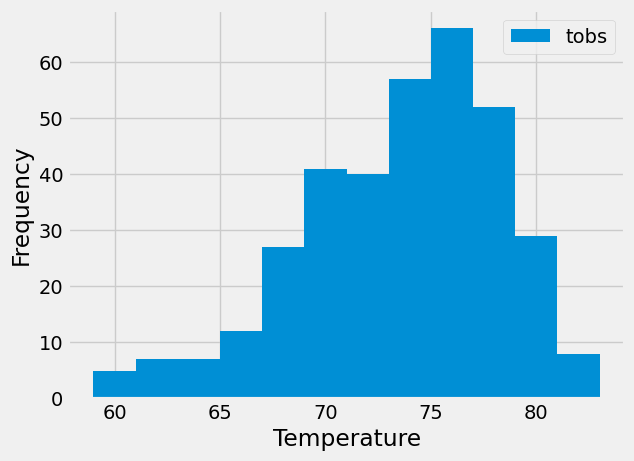

In [91]:
# Using the most active station id - use the DataFrame created temp_df 
# To plot the histogram
plt.hist(temp_df['tobs'], bins=12, label='tobs')

# Set the x and y labels
plt.xlabel('Temperature')
plt.ylabel('Frequency')

# Add grid lines
plt.grid(True)

# Set the legend
plt.legend(loc='upper right')

# Show the plot
plt.show()

# Close Session

In [92]:
# Close Session
session.close()